In [58]:
from tqdm import tqdm

import numpy as np
import pandas as pd

import yfinance as yf

import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

risk_free_rate = 0.03
trial_n = 10000

tickers = ['NKE', 'MSFT', 'DIS', 'COST']

#start = '2012-1-1'
#end = '2022-3-1'
start = '2012-1-1'
end = '2022-1-1'


df_close = yf.download(tickers, start, end, interval='1mo')['Close']

df_close.to_csv('./data/df_close.csv')

[*********************100%***********************]  4 of 4 completed


In [59]:
df_close.shape

(120, 4)

In [60]:
df_close.head()

,COST,DIS,MSFT,NKE
Date,,,,
2012-01-01 00:00:00-05:00,82.269997,38.900002,29.530001,25.997499
2012-02-01 00:00:00-05:00,86.059998,41.990002,31.740000,26.980000
2012-03-01 00:00:00-05:00,90.800003,43.779999,32.259998,27.110001
2012-04-01 00:00:00-04:00,88.180000,43.110001,32.020000,27.967501
2012-05-01 00:00:00-04:00,86.389999,45.709999,29.190001,27.045000


In [61]:
df_close.tail()

,COST,DIS,MSFT,NKE
Date,,,,
2021-08-01 00:00:00-04:00,455.489990,181.300003,301.880005,164.740005
2021-09-01 00:00:00-04:00,449.350006,169.169998,281.920013,145.229996
2021-10-01 00:00:00-04:00,491.540009,169.070007,331.619995,167.289993
2021-11-01 00:00:00-04:00,539.380005,144.899994,330.589996,169.240005
2021-12-01 00:00:00-05:00,567.700012,154.889999,336.320007,166.669998


In [62]:
df_close.isnull().sum()

COST    0
DIS     0
MSFT    0
NKE     0
dtype: int64

In [63]:
if df_close.isnull().values.any():
    df_close.fillna(method='ffill', inplace = True) #front fills
    df_close.fillna(method='bfill', inplace = True) #back fills

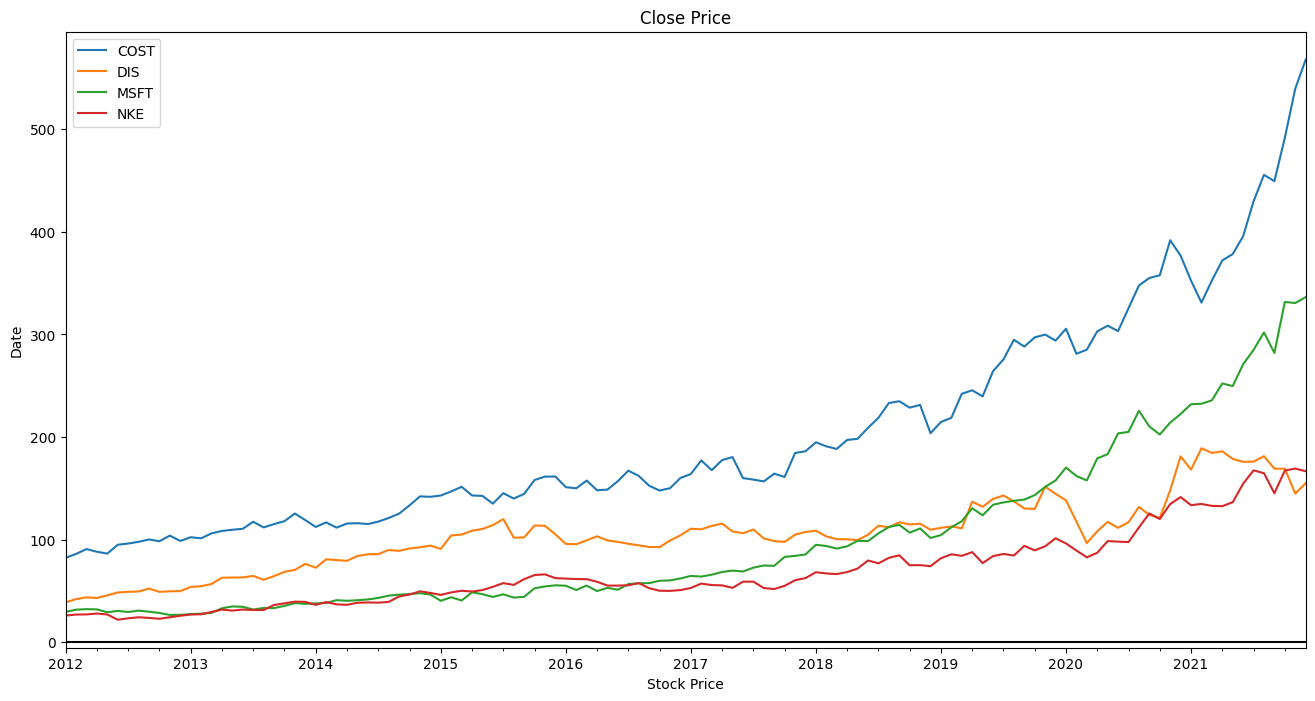

In [64]:
#matplotlib
ax = df_close.plot(title = 'Close Price', figsize=(16, 8), ax = None)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Date')
ax.axhline(y=0, color = 'black')
ax.legend(loc='upper left')
plt.show()

#plotly
fig = px.line(df_close, title = 'Close Price')
fig.update_layout(xaxis_title='Date', yaxis_title='Stock Price',showlegend=True, template='seaborn')
fig.show()

In [65]:
df_pct_change = df_close.pct_change().iloc[1:] #get rid of last row
df_pct_change.head()

,COST,DIS,MSFT,NKE
Date,,,,
2012-02-01 00:00:00-05:00,0.046068,0.079434,0.074839,0.037792
2012-03-01 00:00:00-05:00,0.055078,0.042629,0.016383,0.004818
2012-04-01 00:00:00-04:00,-0.028855,-0.015304,-0.007439,0.031630
2012-05-01 00:00:00-04:00,-0.020299,0.060311,-0.088382,-0.032985
2012-06-01 00:00:00-04:00,0.099664,0.061037,0.047962,-0.188575


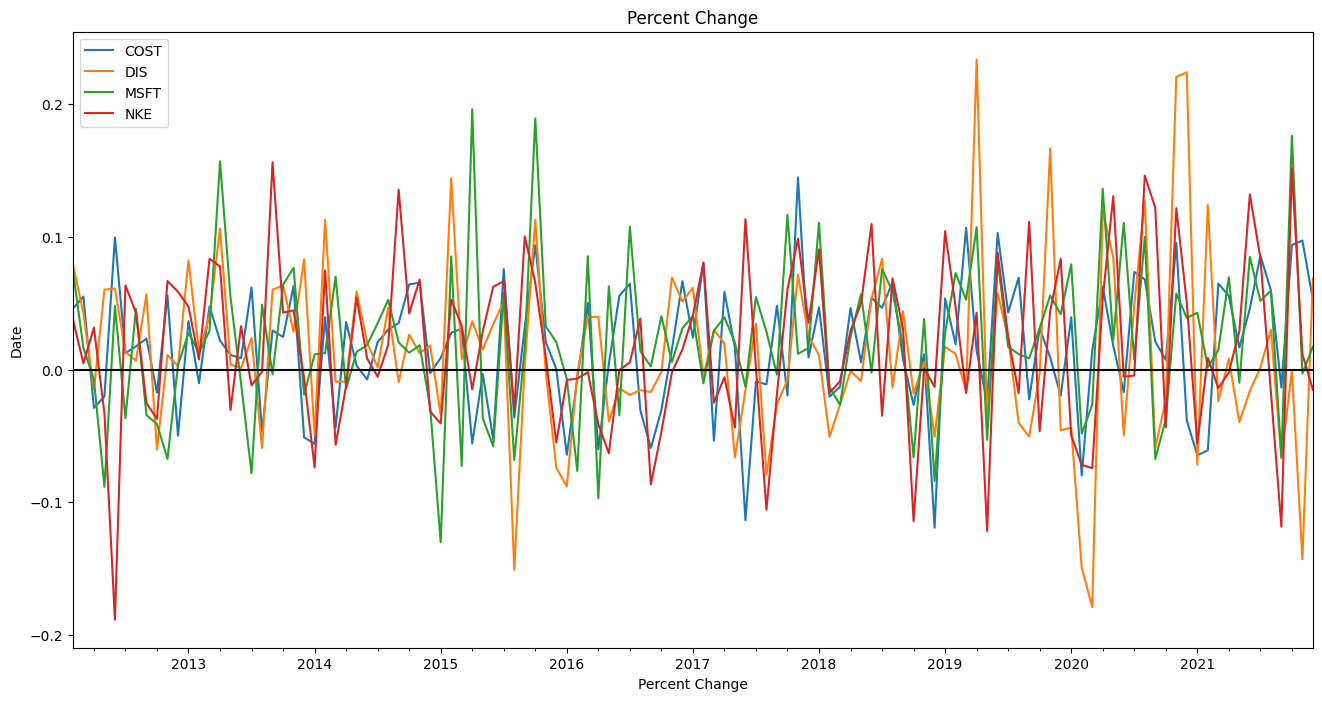

In [66]:
#matplotlib
ax = df_pct_change.plot(title = 'Percent Change', figsize=(16, 8), ax = None)
ax.set_xlabel('Percent Change')
ax.set_ylabel('Date')
ax.axhline(y=0, color = 'black')
ax.legend(loc='upper left')
plt.show()

#plotly
fig = px.line(df_pct_change, title = 'Percent Change')
fig.update_layout(xaxis_title='Date', yaxis_title='Percent Change',showlegend=True, template='seaborn')
fig.show()

In [67]:
mean_return = df_pct_change.mean() * 12
mean_return

COST    0.210163
DIS     0.166885
MSFT    0.267666
NKE     0.212343
dtype: float64

In [68]:
var_risk = df_pct_change.var() * 12
var_risk

COST    0.027995
DIS     0.055262
MSFT    0.041114
NKE     0.047685
dtype: float64

In [69]:
cov_mat = df_pct_change.cov()*12
cov_mat

,COST,DIS,MSFT,NKE
COST,0.027995,0.010468,0.010946,0.011377
DIS,0.010468,0.055262,0.016682,0.019448
MSFT,0.010946,0.016682,0.041114,0.012376
NKE,0.011377,0.019448,0.012376,0.047685


In [70]:
corr_mat = df_pct_change.corr()
corr_mat

,COST,DIS,MSFT,NKE
COST,1.000000,0.266133,0.322651,0.311372
DIS,0.266133,1.000000,0.349985,0.378852
MSFT,0.322651,0.349985,1.000000,0.279516
NKE,0.311372,0.378852,0.279516,1.000000


In [71]:
fig = px.imshow(corr_mat, title='Correlation Heatmap')
fig.show()

In [72]:
weight = 1/len(tickers)
eq_weights = [weight for i in tickers]
eq_weights

[0.25, 0.25, 0.25, 0.25]

In [73]:
eq_return = eq_weights @ (mean_return)
eq_return

0.21426419041415923

In [74]:
eq_risk = ((eq_weights @ cov_mat) @ eq_weights)**(1/2)
eq_risk

0.14462260526809836

In [75]:
eq_sharpe = (eq_return - risk_free_rate)/eq_risk
eq_sharpe

1.2741036580870198

In [76]:
efficient_frontier_data = []
for trial in tqdm(range(trial_n)):
    t_weight = np.random.random(len(tickers, ))
    t_weights = t_weight/sum(t_weight)
    t_return = t_weights @ (mean_return)
    t_risk = ((t_weights @ cov_mat) @ t_weights)**(1/2)
    t_sharpe = (t_return - risk_free_rate)/t_risk
    efficient_frontier_data.append([t_weights, t_risk, t_return, t_sharpe])

efficient_frontier_data = pd.DataFrame(efficient_frontier_data, columns=['Weights', 'Risk', 'Return', 'Sharpe'])
efficient_frontier_data.head()

100%|██████████| 10000/10000 [00:01<00:00, 6853.88it/s]


,Weights,Risk,Return,Sharpe
0,"[0.16581993139373716, 0.11754016261734399, 0.5...",0.151425,0.235139,1.354726
1,"[0.11462093630412344, 0.2609688258181101, 0.28...",0.153244,0.216172,1.214878
2,"[0.14017561525873676, 0.09756771207104017, 0.3...",0.151278,0.229163,1.316533
3,"[0.24338594259130042, 0.14056205029475566, 0.5...",0.150489,0.234487,1.358818
4,"[0.36806434971694457, 0.1496633405121006, 0.08...",0.147189,0.209275,1.217991


In [77]:
i_max_sharpe = efficient_frontier_data['Sharpe'].idxmax()
max_sharpe = efficient_frontier_data.iloc[i_max_sharpe, :]
max_sharpe

Weights    [0.3836665291658794, 0.0016299236070434382, 0....
Risk                                                0.142704
Return                                               0.23397
Sharpe                                              1.429318
Name: 3710, dtype: object

In [78]:
i_min_risk = efficient_frontier_data['Risk'].idxmin()
min_risk = efficient_frontier_data.iloc[i_min_risk, :]
min_risk

Weights    [0.4802906044657866, 0.11857859319884524, 0.21...
Risk                                                 0.13773
Return                                              0.217947
Sharpe                                              1.364599
Name: 8531, dtype: object

In [79]:
i_max_return = efficient_frontier_data['Return'].idxmax()
max_return = efficient_frontier_data.iloc[i_max_return, :]
max_return

Weights    [0.01933348828479314, 0.012967978251421422, 0....
Risk                                                 0.19686
Return                                              0.264641
Sharpe                                              1.191919
Name: 3702, dtype: object

In [80]:
print(eq_risk, eq_return)
print(max_sharpe['Risk'], max_sharpe['Return'])


0.14462260526809836 0.21426419041415923
0.14270435582553384 0.23396985405445528


In [81]:
from plotly import graph_objects as go


def addMarker(fig, x, y, color):
    fig.add_trace(
        go.Scatter(
            x=[x],
            y=[y],
            mode="markers",
            marker_symbol='star',
            marker_size=10,
            marker_color=color
        )
    )


In [82]:
fig = px.scatter(efficient_frontier_data, x='Risk', y='Return', title='Efficient Frontier', color='Risk')
addMarker(fig, max_sharpe['Risk'], max_sharpe['Return'], 'Green')
addMarker(fig, min_risk['Risk'], min_risk['Return'], 'Cyan')
addMarker(fig, max_return['Risk'], max_return['Return'], 'Red')
fig.show()

## DOWNLOAD DATA FOR SAME PORTFOLIO FOR THIS RECENT PAST YEAR

In [85]:
tickers = ['NKE', 'MSFT', 'DIS', 'COST']

start = '2022-1-1'
end = '2023-1-1'

df_recent_close = yf.download(tickers, start, end, interval='1d')['Close']

df_recent_close.to_csv('./data/df_recent_close.csv')

[*********************100%***********************]  4 of 4 completed


In [86]:
df_recent_close.shape

(120, 4)

In [88]:
df_recent_close.head()

,COST,DIS,MSFT,NKE
Date,,,,
2022-01-03 00:00:00-05:00,566.710022,156.759995,334.750000,164.669998
2022-01-04 00:00:00-05:00,564.229980,155.729996,329.010010,166.389999
2022-01-05 00:00:00-05:00,549.919983,155.190002,316.380005,162.250000
2022-01-06 00:00:00-05:00,549.799988,156.899994,313.880005,161.039993
2022-01-07 00:00:00-05:00,536.179993,157.830002,314.040009,156.970001


In [89]:
df_recent_close.tail()

,COST,DIS,MSFT,NKE
Date,,,,
2022-12-23 00:00:00-05:00,462.649994,88.010002,238.729996,116.250000
2022-12-27 00:00:00-05:00,458.500000,86.370003,236.960007,117.559998
2022-12-28 00:00:00-05:00,452.989990,84.169998,234.529999,114.980003
2022-12-29 00:00:00-05:00,456.529999,87.180000,241.009995,117.349998
2022-12-30 00:00:00-05:00,456.500000,86.879997,239.820007,117.010002


In [90]:
df_recent_close.isnull().sum()

COST    0
DIS     0
MSFT    0
NKE     0
dtype: int64

In [91]:
if df_close.isnull().values.any():
    df_close.fillna(method='ffill', inplace = True) #front fills
    df_close.fillna(method='bfill', inplace = True) #back fills

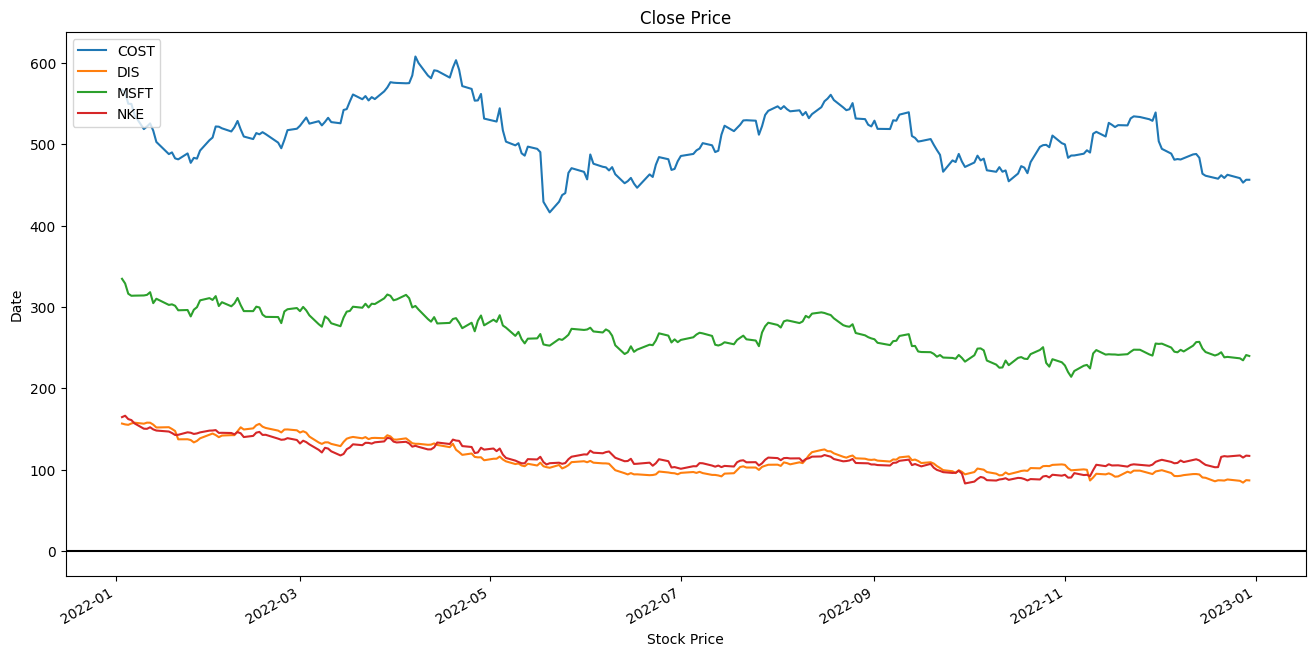

In [93]:
#matplotlib
ax = df_recent_close.plot(title = 'Close Price', figsize=(16, 8), ax = None)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Date')
ax.axhline(y=0, color = 'black')
ax.legend(loc='upper left')
plt.show()

#plotly
fig = px.line(df_recent_close, title = 'Close Price')
fig.update_layout(xaxis_title='Date', yaxis_title='Stock Price',showlegend=True, template='seaborn')
fig.show()

## DOWNLOAD DATA FOR SPY FOR THIS RECENT PAST YEAR

In [94]:
tickers = ['SPY']

start = '2022-1-1'
end = '2023-1-1'

df_recent_close = yf.download(tickers, start, end, interval='1d')['Close']

df_recent_close.to_csv('./data/df_spy_close.csv')

[*********************100%***********************]  1 of 1 completed
